In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import History

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data
file_path = "/content/drive/MyDrive/Colab Notebooks/Real_Combine.csv"  # Update the path to where your file is located
data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Score for fold 1: accuracy of 85.90909242630005%
7/7 [==============================] - 0s 3ms/step
Score for fold 2: accuracy of 82.27272629737854%
7/7 [==============================] - 0s 2ms/step
Score for fold 3: accuracy of 83.1818163394928%
7/7 [==============================] - 0s 2ms/step
Score for fold 4: accuracy of 91.78082346916199%
7/7 [==============================] - 0s 4ms/step
Score for fold 5: accuracy of 92.2374427318573%
7/7 [==============================] - 0s 2ms/step


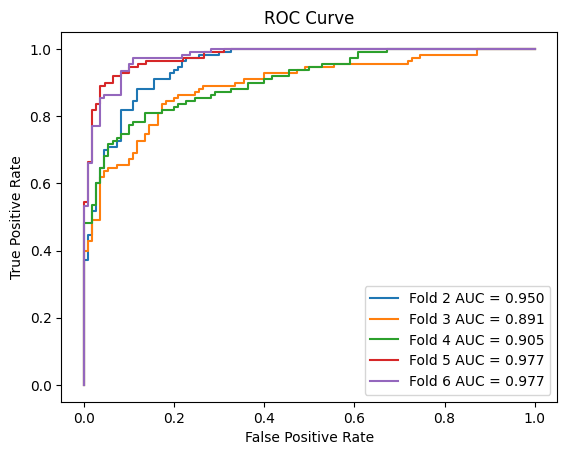

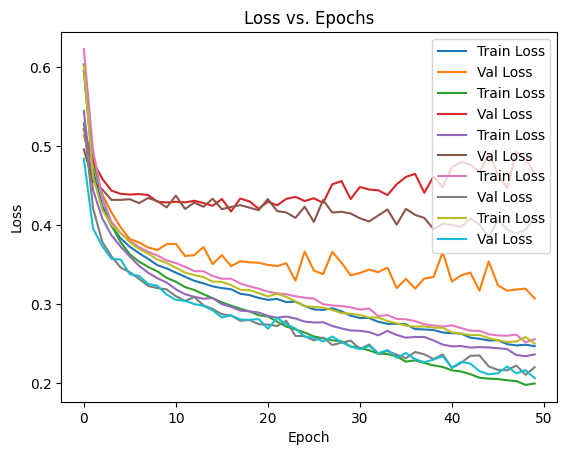

In [5]:
data['Target'] = (data['PM 2.5'] > data['PM 2.5'].median()).astype(int)  # Create binary classes based on median
features = data.drop(['PM 2.5', 'Target'], axis=1)
target = data['Target']

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Handling class imbalance
smote = SMOTE()
features_balanced, target_balanced = smote.fit_resample(features, target)

# Model configuration
def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(features_balanced.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Cross-validation and training
skf = StratifiedKFold(n_splits=5)
fold_no = 1
for train, test in skf.split(features_balanced, target_balanced):
    model = build_model()
    history = model.fit(features_balanced[train], target_balanced[train], validation_data=(features_balanced[test], target_balanced[test]), epochs=50, verbose=0)
    scores = model.evaluate(features_balanced[test], target_balanced[test], verbose=0)

    print(f"Score for fold {fold_no}: {model.metrics_names[1]} of {scores[1]*100}%")
    fold_no += 1

    # ROC Curve
    y_pred = model.predict(features_balanced[test]).ravel()
    fpr, tpr, thresholds = roc_curve(target_balanced[test], y_pred)
    auc_score = auc(fpr, tpr)
    plt.figure(1)
    plt.plot(fpr, tpr, label=f"Fold {fold_no} AUC = {auc_score:.3f}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')

    # Loss vs. Epoch
    plt.figure(2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.figure(1).show()
    plt.figure(2).show()
